In [1]:
from src.densite_function import *
from src.gaussian_simulation import *
from src.estimators import *
from src.vraisemblance import *
import numpy as np
from numpy.linalg import norm 
import matplotlib.pylab as plt

# Préalable

On tire $\mathbf{x}$ et $\theta$ au hasard dans $\mathbb{R}^{20}$ et on fixe les paramètres optimaux $A^*$ et $b^*$ (voir Rainforth 2018). Puis, on génére les paramètres $A$ et $b$ en ajoutant un bruit gaussien.

In [2]:
np.random.seed(8878)

theta=simulate_gaussian_vector(mu=np.array([0]*20), sigma=np.identity(20))
x=simulate_gaussian_vector(mu=theta, sigma=2*np.identity(20))

A_optimal=np.matrix(np.identity(20))*0.5
b_optimal=theta/2

A=A_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))
b=b_optimal+simulate_gaussian_vector(mu=np.array([0]*20), sigma=0.01*np.identity(20))

# Estimateurs de la log-vraisemblance

## Comparaison entre estimateurs et vraie log-vraisemblance au point x

On prend $k=6$ pour l'estimateur IAWE, $l=6$ pour les autres.

In [3]:
np.random.seed(589)
print("Vraie valeur de la log-vraisemblance au point x: {}".format(np.around(log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE de la log-vraisemblance: {}".format(np.around(importance_sampling_logvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=6), decimals=2)))
print("Estimateur ML-SS de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_logvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))
print("Estimateur ML-RR de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_logvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))

Vraie valeur de la log-vraisemblance au point x: -35.68
Estimateur IAWE de la log-vraisemblance: -36.63
Estimateur SUMO de la log-vraisemblance: -33.37
Estimateur ML-SS de la log-vraisemblance: -35.92
Estimateur ML-RR de la log-vraisemblance: -35.41


## Procédure de Monte Carlo

Le coût espéré d'échantillonage est:

\begin{equation}

    C=\frac{r.2^{l+1}}{1-2(1-r)} = 6 \times 2^{l}

\end{equation}

Avec $r=0.6$.

Donc, $\forall{C=6, 7,..., 384}$, on cherche $l_C \approx \frac{\log(\frac{C}{6})}{\log(2)}$

In [4]:
list_couts=[c for c in range(6, 385)]
list_l=np.array([(np.log(c/6)/np.log(2)) for c in list_couts])
list_l=np.unique(np.around(list_l))
list_l = np.delete(list_l, 0) #On supprime l=0 (inutile)
print(list_l)

[1. 2. 3. 4. 5. 6.]


On met en place une procédure de Monte Carlo pour estimer le biais et la variance des estimateurs, en fonction du coût computationel pour chaque méthode ($k$: le nombre d'observations générées selon la loi de proposition pour IAWE, $l$: la période de chauffe pour les autres méthodes).

L'algorithme est le suivant: (on confond $k$ et $l$ pour plus de simplicité)

Pour $l$ allant de 1 à 6, faire:

Pour m allant de 1 à M, faire:

Calculer chaque estimateur au point $\mathbb{x}$: $estimateur_{m,l}$

Calculer:

\begin{equation}

    biais_{M,l}=\frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l} - l(x;\theta)

\end{equation}

\begin{equation}

    Var_{M,l}=\frac{1}{M} \sum_{m=1}^{M}( estimateur_{m,l} - \frac{1}{M} \sum_{m=1}^{M} estimateur_{m,l})^{2}

\end{equation}

Fin pour

Fin pour

Retourner $biais_{M,1}, ..., biais_{M,6}, Var_{M,1}, ..., Var_{M,6}$

Les auteurs de l'article prennent $M=1000$.

In [5]:
def procedure_MC_logvraisemblance(M, L, x, theta, A, b):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=1
    while l<=L:
        print(l)
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            log_vraisemblance_estim_IWAE=importance_sampling_logvraisemblance(k=l, theta=theta, A=A, b=b, x=x)
            log_vraisemblance_estim_SUMO=estimateur_SUMO_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_SS=estimateur_ML_SS_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            log_vraisemblance_estim_RR=estimateur_ML_RR_logvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)


            estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, log_vraisemblance_estim_IWAE)
            estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, log_vraisemblance_estim_SUMO)
            estimations_SS_M_l=np.append(estimations_SS_M_l, log_vraisemblance_estim_SS)
            estimations_RR_M_l=np.append(estimations_RR_M_l, log_vraisemblance_estim_RR)
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l)-log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l)-log_vraisemblance(x=x, theta=theta)

        var_IWAE_M_l=np.var(estimations_IWAE_M_l)
        var_SUMO_M_l=np.var(estimations_SUMO_M_l)
        var_SS_M_l=np.var(estimations_SS_M_l)
        var_RR_M_l=np.var(estimations_RR_M_l)

        biais_IWAE_M[l]=biais_IWAE_M_l
        biais_SUMO_M[l]=biais_SUMO_M_l
        biais_SS_M[l]=biais_SS_M_l
        biais_RR_M[l]=biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [6]:
np.random.seed(8554)

biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M = procedure_MC_logvraisemblance(M=1000, 
                                                                                                                               L=6, 
                                                                                                                               x=x, 
                                                                                                                               theta=theta, 
                                                                                                                               A=A, 
                                                                                                                               b=b)


1
2
3
4
5
6


C:\Users\yanis\AppData\Local\Temp\ipykernel_114332\1760897713.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, np.square(biais_IAWE), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_114332\1760897713.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, np.square(biais_SUMO), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_114332\1760897713.py:27: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, np.square(biais_SS), 'b', label="Biais au

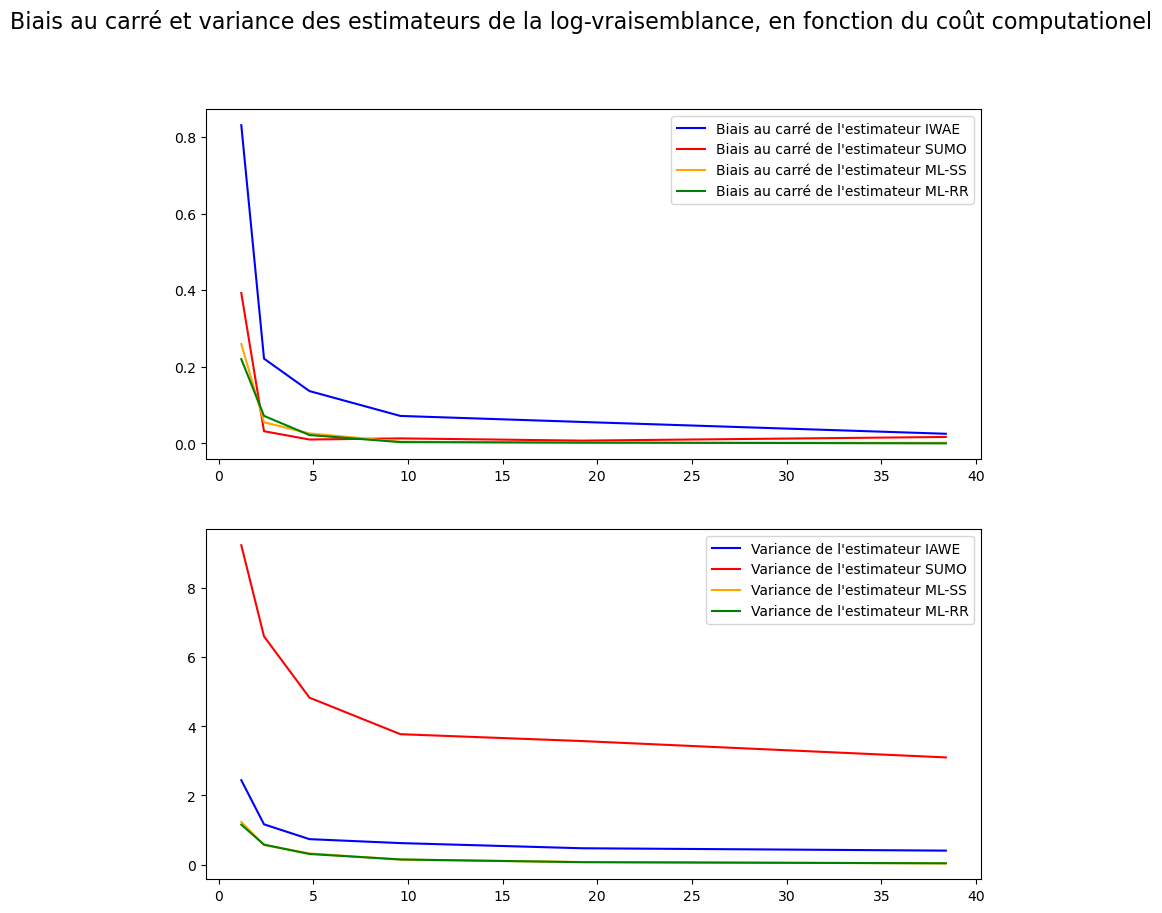

In [11]:
sorted_biais_IWAE_M = sorted(biais_IWAE_M.items())
sorted_biais_SUMO_M = sorted(biais_SUMO_M.items())
sorted_biais_SS_M = sorted(biais_SS_M.items())
sorted_biais_RR_M = sorted(biais_RR_M.items())

sorted_var_IWAE_M = sorted(var_IWAE_M.items())
sorted_var_SUMO_M = sorted(var_SUMO_M.items())
sorted_var_SS_M = sorted(var_SS_M.items())
sorted_var_RR_M = sorted(var_RR_M.items())

l, biais_IAWE = zip(*sorted_biais_IWAE_M)
l, biais_SUMO = zip(*sorted_biais_SUMO_M)
l, biais_SS = zip(*sorted_biais_SS_M)
l, biais_RR = zip(*sorted_biais_RR_M)

l, var_IAWE = zip(*sorted_var_IWAE_M) 
l, var_SUMO = zip(*sorted_var_SUMO_M) 
l, var_SS = zip(*sorted_var_SS_M) 
l, var_RR = zip(*sorted_var_RR_M) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

list_c=[0.3*2**(l+1) for l in list_l]

axs[0].plot(list_c, np.square(biais_IAWE), 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(list_c, np.square(biais_SUMO), 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(list_c, np.square(biais_SS), 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(list_c, np.square(biais_RR), 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(list_c, var_IAWE, 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(list_c, var_SUMO, 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(list_c, var_SS, 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(list_c, var_RR, 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()

# Estimateurs du gradient de la log-vraisemblance

## Comparaison entre estimateurs et vrai gradient au point x

On estime le gradient de la  log-vraisemblance au point $\mathbf{x}$ avec $k=6$ et $l=6$.

In [5]:
np.random.seed(589)
print("Vraie valeur du gradient de la log-vraisemblance au point x: {}".format(np.around(gradient_log_vraisemblance(x, theta), decimals=2)))
print("Estimateur IAWE du gradient de la log-vraisemblance: {}".format(np.around(importance_sampling_gradientlogvraisemblance(k=6, theta=theta, A=A, b=b, x=x), decimals=2)))
print("Estimateur SUMO du gradient de la log-vraisemblance: {}".format(np.around(estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=6), decimals=2)))
print("Estimateur ML-SS du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_SS_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))
print("Estimateur ML-RR du gradient de la log-vraisemblance: {}".format(np.around(estimateur_ML_RR_gradientlogvraisemblance(x, theta, A, b, r=0.6, l=6), decimals=2)))

Vraie valeur du gradient de la log-vraisemblance au point x: [-0.56 -0.14  5.68 -1.59  0.35 -3.65 -1.39 -5.28 -0.74 -1.42 -2.03 -0.48
  1.42  4.72  0.91  4.48  1.94  3.69 -0.3  -4.25]
Estimateur IAWE du gradient de la log-vraisemblance: [ 0.02 -0.2   1.88 -0.2   0.37 -0.43 -0.16 -1.59 -0.12 -0.55 -0.76 -0.14
  1.16  1.26 -0.71  1.25  0.67  1.31  0.45 -0.58]
Estimateur SUMO du gradient de la log-vraisemblance: [-1.61 -1.85  1.24 -1.87 -1.08  0.52  1.04 -2.49  1.36 -0.16  1.3  -2.31
  2.57 -0.06  0.13  0.17  0.2   2.45 -0.39 -3.01]
Estimateur ML-SS du gradient de la log-vraisemblance: [ 2.07 -0.02  2.09 -0.33 -0.06 -0.68 -0.61 -0.95 -0.07 -0.24 -0.51  0.09
  0.75  1.49  0.28  1.56  0.65  0.82  0.32 -0.55]
Estimateur ML-RR du gradient de la log-vraisemblance: [ 0.87  1.16  2.53  0.85  0.93 -0.09  0.65 -0.29  0.9   0.61  0.75  1.25
  1.1   2.27  1.37  1.95  1.55  2.01  1.1  -0.14]


## Procédure de Monte Carlo

Le gradient de la log-vraisemblance ainsi que les différents estimateurs associés sont dans $\mathbb{R}^{20}$. Ainsi, on adapte la définition du biais au carré et de la variance, de sorte à avoir une valeur réelle.

\begin{equation}

    biais_M=\frac{1}{M} \sum_{m=1}^{M} estimateur_m - \nabla_{\theta}l(x;\theta)

\end{equation}

\begin{equation}

    biais^2_M=\lVert biais_M \rVert^2

\end{equation}

\begin{equation}

    Var_M=\frac{1}{M} \sum_{m=1}^{M} \lVert estimateur_m - \frac{1}{M} \sum_{m=1}^{M} estimateur_m \rVert^{2}

\end{equation}

In [11]:
list_c=[0.3*2**(l+1) for l in [1,2,3]]

In [7]:
def procedure_MC_gradientlogvraisemblance(M, L, x, theta, A, b):

    biais_IWAE_M={}
    biais_SUMO_M={}
    biais_SS_M={}
    biais_RR_M={}

    var_IWAE_M={}
    var_SUMO_M={}
    var_SS_M={}
    var_RR_M={}

    l=1
    while l<=L:
        print(l)
        m=1
        estimations_IWAE_M_l=np.array([])
        estimations_SUMO_M_l=np.array([])
        estimations_SS_M_l=np.array([])
        estimations_RR_M_l=np.array([])


        while m<=M:
            gradient_log_vraisemblance_estim_IWAE=importance_sampling_gradientlogvraisemblance(k=l, theta=theta, A=A, b=b, x=x)
            gradient_log_vraisemblance_estim_SUMO=estimateur_SUMO_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_SS=estimateur_ML_SS_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)
            gradient_log_vraisemblance_estim_RR=estimateur_ML_RR_gradientlogvraisemblance(theta=theta, A=A, b=b, x=x, r=0.6, l=l)

            if m==1:
                estimations_IWAE_M_l= np.append(estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE)
                estimations_SUMO_M_l=np.append(estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO)
                estimations_SS_M_l=np.append(estimations_SS_M_l, gradient_log_vraisemblance_estim_SS)
                estimations_RR_M_l=np.append(estimations_RR_M_l, gradient_log_vraisemblance_estim_RR)
            
            else:
                estimations_IWAE_M_l= np.vstack((estimations_IWAE_M_l, gradient_log_vraisemblance_estim_IWAE))
                estimations_SUMO_M_l=np.vstack((estimations_SUMO_M_l, gradient_log_vraisemblance_estim_SUMO))
                estimations_SS_M_l=np.vstack((estimations_SS_M_l, gradient_log_vraisemblance_estim_SS))
                estimations_RR_M_l=np.vstack((estimations_RR_M_l, gradient_log_vraisemblance_estim_RR))
            m+=1
        
        biais_IWAE_M_l=np.mean(estimations_IWAE_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SUMO_M_l=np.mean(estimations_SUMO_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_SS_M_l=np.mean(estimations_SS_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)
        biais_RR_M_l=np.mean(estimations_RR_M_l, axis=0)-gradient_log_vraisemblance(x=x, theta=theta)

        squared_biais_IWAE_M_l=norm(biais_IWAE_M_l)**2
        squared_biais_SUMO_M_l=norm(biais_SUMO_M_l)**2
        squared_biais_SS_M_l=norm(biais_SS_M_l)**2
        squared_biais_RR_M_l=norm(biais_RR_M_l)**2

        var_IWAE_M_l=np.mean(norm(estimations_IWAE_M_l-np.mean(estimations_IWAE_M_l, axis=0))**2)
        var_SUMO_M_l=np.mean(norm(estimations_SUMO_M_l-np.mean(estimations_SUMO_M_l, axis=0))**2)
        var_SS_M_l=np.mean(norm(estimations_SS_M_l-np.mean(estimations_SS_M_l, axis=0))**2)
        var_RR_M_l=np.mean(norm(estimations_RR_M_l-np.mean(estimations_RR_M_l, axis=0))**2)

        biais_IWAE_M[l]=squared_biais_IWAE_M_l
        biais_SUMO_M[l]=squared_biais_SUMO_M_l
        biais_SS_M[l]=squared_biais_SS_M_l
        biais_RR_M[l]=squared_biais_RR_M_l

        var_IWAE_M[l]=var_IWAE_M_l
        var_SUMO_M[l]=var_SUMO_M_l
        var_SS_M[l]=var_SS_M_l
        var_RR_M[l]=var_RR_M_l

        l+=1

    return biais_IWAE_M, biais_SUMO_M, biais_SS_M, biais_RR_M, var_IWAE_M, var_SUMO_M, var_SS_M, var_RR_M

In [8]:
np.random.seed(8554)

biais_IWAE_M_gradient, biais_SUMO_M_gradient, biais_SS_M_gradient, biais_RR_M_gradient, var_IWAE_M_gradient, var_SUMO_M_gradient, var_SS_M_gradient, var_RR_M_gradient = procedure_MC_gradientlogvraisemblance(M=1000, 
                                                                                                                                                                                                        L=3, 
                                                                                                                                                                                                        x=x, 
                                                                                                                                                                                                        theta=theta, 
                                                                                                                                                                                                        A=A, 
                                                                                                                                                                                                        b=b)

1
2
3


C:\Users\yanis\AppData\Local\Temp\ipykernel_124880\2383704016.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, biais_IAWE_gradient, 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
C:\Users\yanis\AppData\Local\Temp\ipykernel_124880\2383704016.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, biais_SUMO_gradient, 'b', label="Biais au carré de l'estimateur SUMO", color="red")
C:\Users\yanis\AppData\Local\Temp\ipykernel_124880\2383704016.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  axs[0].plot(list_c, biais_SS_gradient, 'b', label="Biais au carré

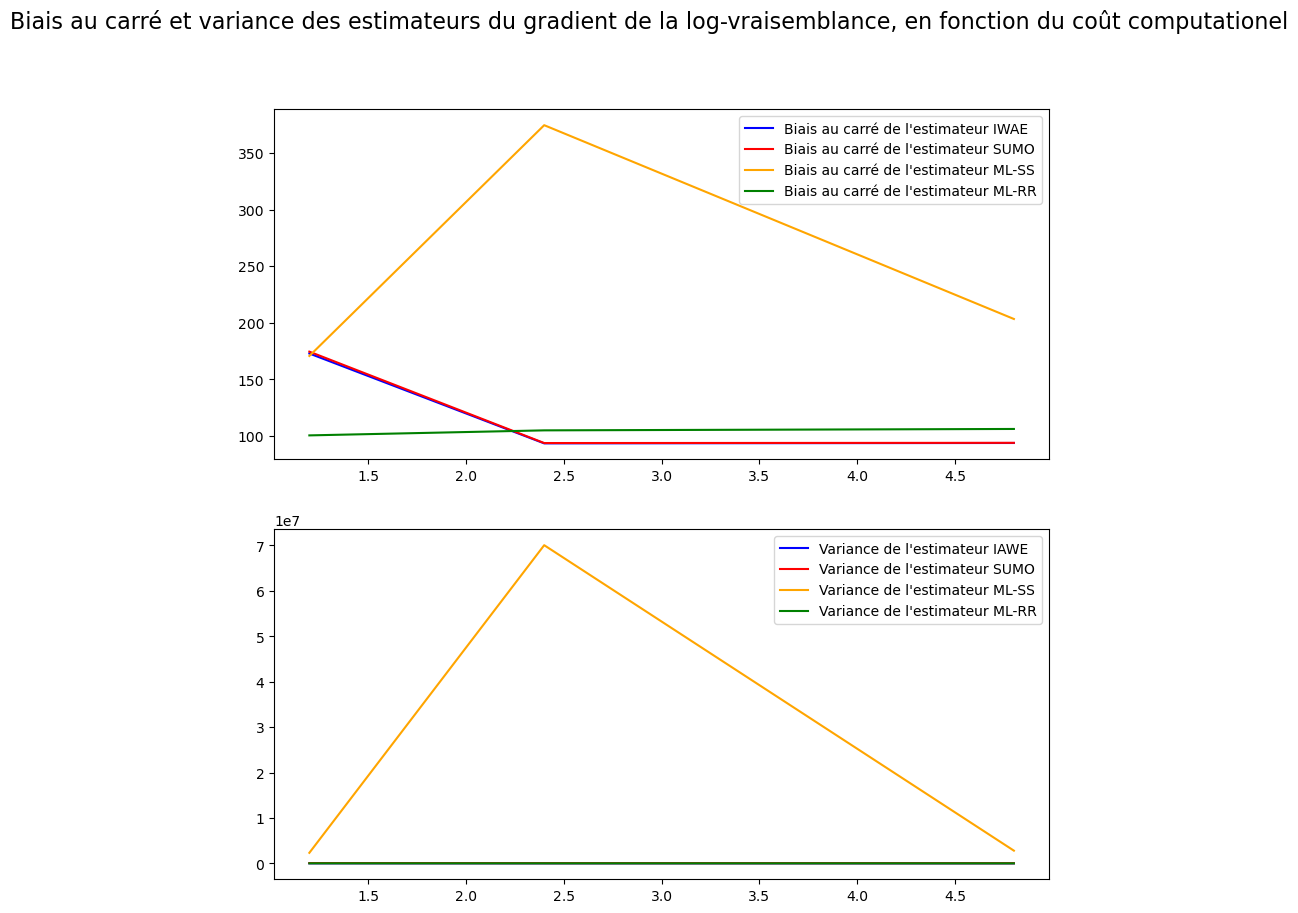

In [12]:
sorted_biais_IWAE_M_gradient = sorted(biais_IWAE_M_gradient.items())
sorted_biais_SUMO_M_gradient = sorted(biais_SUMO_M_gradient.items())
sorted_biais_SS_M_gradient = sorted(biais_SS_M_gradient.items())
sorted_biais_RR_M_gradient = sorted(biais_RR_M_gradient.items())

sorted_var_IWAE_M_gradient = sorted(var_IWAE_M_gradient.items())
sorted_var_SUMO_M_gradient = sorted(var_SUMO_M_gradient.items())
sorted_var_SS_M_gradient = sorted(var_SS_M_gradient.items())
sorted_var_RR_M_gradient = sorted(var_RR_M_gradient.items())

l, biais_IAWE_gradient = zip(*sorted_biais_IWAE_M_gradient)
l, biais_SUMO_gradient = zip(*sorted_biais_SUMO_M_gradient)
l, biais_SS_gradient = zip(*sorted_biais_SS_M_gradient)
l, biais_RR_gradient = zip(*sorted_biais_RR_M_gradient)

l, var_IAWE_gradient = zip(*sorted_var_IWAE_M_gradient) 
l, var_SUMO_gradient = zip(*sorted_var_SUMO_M_gradient) 
l, var_SS_gradient = zip(*sorted_var_SS_M_gradient) 
l, var_RR_gradient = zip(*sorted_var_RR_M_gradient) 

fig, axs = plt.subplots(2,1, figsize=(10, 10))

axs[0].plot(list_c, biais_IAWE_gradient, 'b', label="Biais au carré de l'estimateur IWAE", color="blue")
axs[0].plot(list_c, biais_SUMO_gradient, 'b', label="Biais au carré de l'estimateur SUMO", color="red")
axs[0].plot(list_c, biais_SS_gradient, 'b', label="Biais au carré de l'estimateur ML-SS", color="orange")
axs[0].plot(list_c, biais_RR_gradient, 'b', label="Biais au carré de l'estimateur ML-RR", color="green")

axs[0].legend()

fig.suptitle('Biais au carré et variance des estimateurs du gradient de la log-vraisemblance, en fonction du coût computationel', fontsize=16)

axs[1].plot(list_c, var_IAWE_gradient, 'b', label="Variance de l'estimateur IAWE", color="blue")
axs[1].plot(list_c, var_SUMO_gradient, 'b', label="Variance de l'estimateur SUMO", color="red")
axs[1].plot(list_c, var_SS_gradient, 'b', label="Variance de l'estimateur ML-SS", color="orange")
axs[1].plot(list_c, var_RR_gradient, 'b', label="Variance de l'estimateur ML-RR", color="green")


axs[1].legend()

plt.show()